In [2]:
%pip install numpy==1.23.5 pandas==1.5.3 scikit-learn==1.2.1
%pip install -U matplotlib==3.6.3

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached scikit_learn-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.6 MB/s eta 0:00:00:00:010:01
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
from datetime import datetime, timedelta

In [5]:
'''import'''

data = pd.read_csv("../../cephfs/cleanedData/2022-02_sample.csv", parse_dates=['GlucoseDisplayTime'])

# Just 1 patient

In [6]:
'''use just one patient'''
patIDs = data.PatientId.unique()
i = 0
subset = data[data['PatientId']==patIDs[i]].copy()
subset

## the actual fill-in-missing-values process

In [7]:
'''replace 0s with NaN to save a two steps down the line'''
subset['Value'] = subset['Value'].replace(0, np.nan)

'''drop duplicate datetimes for each patient'''
subset = subset.drop_duplicates(subset='GlucoseDisplayTime', keep="first")

ogNon0Values = subset['Value'].replace(0, np.nan).count()
print("starting with", ogNon0Values, "nonzero glucose measurements ('Value')")
# print(subset.info())

'''set datetime as index in order for resampling method below to work'''
subset = subset.set_index('GlucoseDisplayTime')
subset.info()

starting with 7700 nonzero glucose measurements ('Value')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8059 entries, 2022-02-01 01:35:54.162000 to 2022-02-28 07:30:36
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientId              8059 non-null   int64  
 1   GlucoseDisplayTimeRaw  8059 non-null   object 
 2   Value                  7700 non-null   float64
 3   dayCSV                 8059 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 314.8+ KB


In [ ]:
'''fill in missing timestamps'''
subset = subset.resample('5min').first()

'''fix columns that *need* to be filled in'''
subset['PatientId'] = subset['PatientId'].replace(np.nan, patIDs[i])
# subset['GlucoseDisplayTimeRaw'] = subset.index.strftime('%Y-%m-%d') #check documentation for how to format
# subset['dayCSV'] = subset['dayCSV'].replace(np.nan, -1)

print(subset.info())
subset

In [9]:
'''resampling has the capacity to lose us some glucose measurements, so check for that'''
newNon0Values = subset['Value'].replace(0, np.nan).count()
if ogNon0Values-newNon0Values > 0:
    print(ogNon0Values-newNon0Values, "glucose measurements lost in resampling")
elif ogNon0Values-newNon0Values < 0:
    print("Somehow resampling *added* glucose measurements and that means something went wrong")

3 glucose measurements lost in resampling


In [10]:
'''label which values need filling'''
subset['missing'] = False
subset.loc[subset['Value'].isna(), 'missing'] = True

# subset.info()
subset.groupby('missing').count()

,PatientId,GlucoseDisplayTimeRaw,Value,dayCSV
missing,,,,
False,7697,7697,7697,7697
True,371,354,0,354


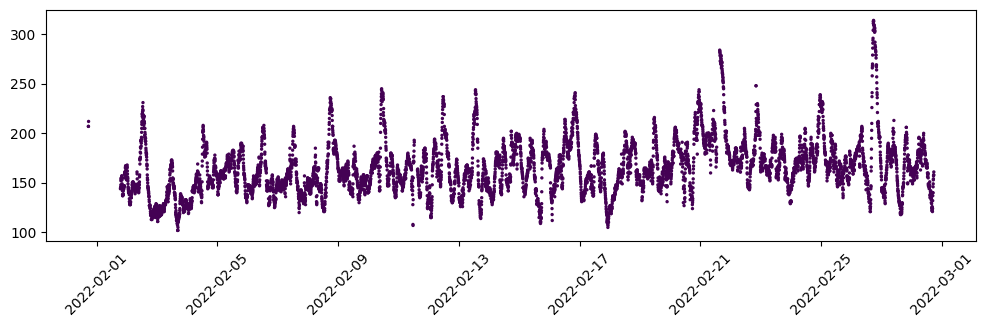

In [11]:
'''pause to visualize'''
plt.figure(figsize=(12,3))
plt.scatter(subset.index, subset.Value, c=subset.missing, s=2)
plt.xticks(rotation=45)
plt.show()

In [ ]:
'''interpolate'''
subset['Value'] = subset['Value'].interpolate(method='pchip')
missing_vals = subset[subset['missing'] == 1].index
for i in missing_vals:
    lower_t = i - timedelta(hours = 5)
    upper_t = i - timedelta(hours = 3)
    std_prev = np.sqrt(np.std(subset.loc[lower_t:upper_t, 'Value']))
    jiggle = std_prev*np.random.randn()
    subset.loc[i, 'Value'] = subset.loc[i, 'Value'] + jiggle

subset

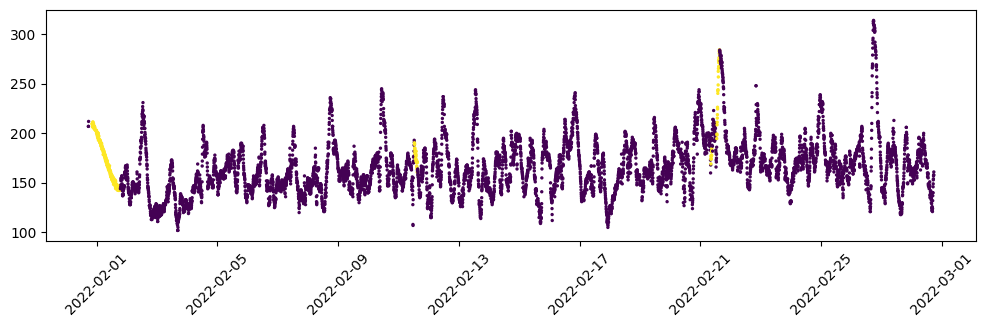

In [13]:
'''pause to visualize'''
plt.figure(figsize=(12,3))
plt.scatter(subset.index, subset.Value, c=subset.missing, s=2)
plt.xticks(rotation=45)
plt.show()

## All patients

In [28]:
def func(subset: pd.DataFrame, patID: int):
    '''replace 0s with NaN to save a two steps down the line'''
    subset['Value'] = subset['Value'].replace(0, np.nan)

    '''drop duplicate datetimes for each patient'''
    subset = subset.drop_duplicates(subset='GlucoseDisplayTime', keep="first")

    ogNon0Values = subset['Value'].replace(0, np.nan).count()
    # print("starting with", ogNon0Values, "nonzero glucose measurements ('Value')")

    '''set datetime as index in order for resampling method below to work'''
    subset = subset.set_index('GlucoseDisplayTime')
    
    '''fill in missing timestamps'''
    subset = subset.resample('5min').first()

    '''fix columns that *need* to be filled in'''
    subset['PatientId'] = subset['PatientId'].replace(np.nan, patID)
    
    '''resampling has the capacity to lose us some glucose measurements, so check for that'''
    newNon0Values = subset['Value'].replace(0, np.nan).count()
    if ogNon0Values-newNon0Values > 0:
        print(ogNon0Values-newNon0Values, "glucose measurements lost in resampling")
    elif ogNon0Values-newNon0Values < 0:
        print("Somehow resampling *added* glucose measurements and that means something went wrong")
        
    '''label which values need filling'''
    subset['missing'] = False
    subset.loc[subset['Value'].isna(), 'missing'] = True
    
    '''interpolate (this part is not optimized)'''
    subset['Value'] = subset['Value'].interpolate(method='pchip')
    missing_vals = subset[subset['missing'] == 1].index
    for i in missing_vals:
        lower_t = i - timedelta(hours = 5)
        upper_t = i - timedelta(hours = 3)
        std_prev = np.sqrt(np.std(subset.loc[lower_t:upper_t, 'Value']))
        jiggle = std_prev*np.random.randn()
        subset.loc[i, 'Value'] = subset.loc[i, 'Value'] + jiggle

    return subset.reset_index()

In [ ]:
'''run it for the entire sampled dataframe'''
newData = pd.DataFrame()
for i in patIDs:
    subset = data[data['PatientId']==i].copy()
    subset = func(subset, i)
    newData = pd.concat([newData, subset], ignore_index=True)
newData

In [31]:
newData.to_csv("../../cephfs/cleanedData/2022-02_sampleFilled.csv")